In [1]:
include("../../src/utilities.jl")
include("../../src/simple_canonical_model_functions.jl")
include("../../src/model_with_ribosomes_functions.jl")
include("../../src/canonical_two_stage_model_with_division_functions.jl")
using Catalyst, DifferentialEquations, PyPlot, Statistics, SpecialFunctions

In [2]:
function beta_3_exact(beta, gamma, rho, T)
    return (3*beta *gamma *(6 *gamma ^2*T^2*
   exp(gamma  *T)-3 *gamma ^2 *T^2-4 *gamma *T*
   exp(gamma*T)+2 *gamma *T+2*exp(gamma *
   T)-2))/(rho*(26 *gamma ^3 *T^3*
   exp(gamma*T)-13 *gamma ^3 *T^3-12 *gamma ^2*
   T^2* exp(gamma  *T)+12 *gamma ^2 *T^2-6 *gamma* 
   T *exp(gamma * T)-6 *gamma  *T+12 *exp(gamma* 
   T)-12))
end

beta_3_exact (generic function with 1 method)

In [3]:
function negative_binomial(x, mean, std)
    p = 1-mean/std^2
    r = mean^2/(std^2-mean)
    return SpecialFunctions.gamma.(x .+ r) ./ (SpecialFunctions.gamma.(x .+ 1) .* SpecialFunctions.gamma.(r)) .* (1-p) .^ r .* p .^x
end

negative_binomial (generic function with 1 method)

In [4]:
function simulate_cycle(model, p, t0, t_fin, T, species_0, saveat)
    tstops = [t0+T:T:t_fin;]
    
    prob = DiscreteProblem(model, species_0, (t0,t_fin), p)
    jump_prob = JumpProblem(model, prob, Direct(), save_positions=(false,false))
        
    condition(u,t,integrator) = t%27.5==0.0
    affect!(integrator) = integrator.u = Utilities.partition_species(integrator.u)
    cb = DiscreteCallback(condition,affect!)
    
    sol = solve(jump_prob, SSAStepper(), saveat=saveat, callback=cb, tstops=tstops)
    return sol
end

function simulate_stochastic_cycle(model, p, t0, t_fin, T, species_0, N, saveat)
   prob = DiscreteProblem(
        model,
        species_0,
        (t0,t_fin),
        p
    )
    jump_prob = JumpProblem(model, prob, Direct())
    
    function affect!(integrator)
        integrator.u = Utilities.partition_species(integrator.u)
        integrator.u[length(integrator.u)] = 0
    end
        
    condition(u,t,integrator) = u[length(u)]==N
    cb = DiscreteCallback(condition,affect!)
    sol = solve(jump_prob, SSAStepper(), callback=cb, saveat=saveat)
    pop!(sol.u)
    pop!(sol.t)
    return sol
end

simulate_stochastic_cycle (generic function with 1 method)

## Model I

In [5]:
sc2s = @reaction_network begin
        alpha,  0-->m
        beta, m-->p + m
        gamma,  m-->0
        delta, p-->0
end alpha beta gamma delta

Model ##ReactionSystem#253 with 4 equations
States (2):
  m(t)
  p(t)
Parameters (4):
  alpha
  beta
  gamma
  delta

In [6]:
alph = 1.0
beta = 0.2
gamma = 1.25*0.2
delta = 0.023
    
prob = DiscreteProblem(sc2s, [round(alph/gamma), round(alph*beta/gamma/delta)], (0.,1000000.), [alph, beta, gamma ,delta])
jump_prob = JumpProblem(sc2s, prob, Direct())

sol = solve(jump_prob, SSAStepper(), saveat=1.0)

retcode: Default
Interpolation: Piecewise constant interpolation
t: 4599617-element Array{Float64,1}:
      0.0
      0.002057217045029897
      0.366442660633625
      0.45475623099253654
      0.6068499037615342
      0.9056371749132455
      1.0
      2.0
      2.8638199594117117
      3.0
      3.824115908375833
      4.0
      4.0498604846752
      ⋮
 999998.0
 999998.2199946665
 999998.4490141985
 999998.4590172278
 999998.6415258973
 999998.6891024639
 999998.8214094718
 999998.9213441303
 999999.0
 999999.1417308918
 999999.4393815708
      1.0e6
u: 4599617-element Array{Array{Float64,1},1}:
 [4.0, 35.0]
 [3.0, 35.0]
 [3.0, 34.0]
 [3.0, 33.0]
 [4.0, 33.0]
 [4.0, 32.0]
 [4.0, 32.0]
 [4.0, 32.0]
 [4.0, 31.0]
 [4.0, 31.0]
 [4.0, 30.0]
 [4.0, 30.0]
 [5.0, 30.0]
 ⋮
 [4.0, 38.0]
 [4.0, 37.0]
 [3.0, 37.0]
 [3.0, 38.0]
 [2.0, 38.0]
 [2.0, 39.0]
 [2.0, 38.0]
 [1.0, 38.0]
 [1.0, 38.0]
 [1.0, 39.0]
 [0.0, 39.0]
 [0.0, 39.0]

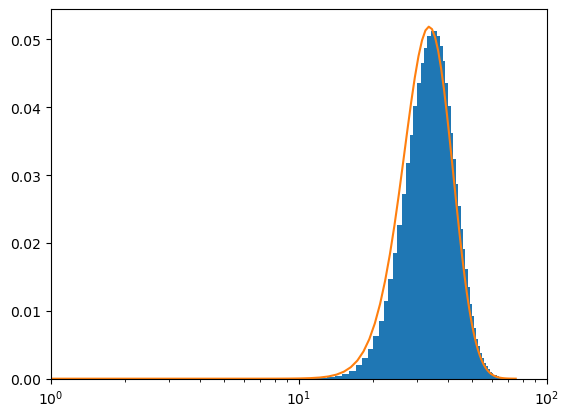

In [7]:
t = sol.t
m = map(x -> x[1], sol.u)
p = map(x -> x[2], sol.u)
min = Int(minimum(p))
max = Int(maximum(p))
bins = Array(min:1:max)

x = LinRange(0,max, max)
y = negative_binomial(
    x,
    SimpleCanonicalModel.p(alph, beta, gamma, delta),
    sqrt(SimpleCanonicalModel.p_var(alph, beta, gamma, delta))
)
hist(p, density=true, bins=bins)
xlim([1,100])
xscale("log")
plot(x,y)
savefig("../../data/distributions/model_I.svg")

In [8]:
println(mean(p))
println(mean(m))

35.46008265470799
4.404157780963067


## Model II

In [9]:
c2s = @reaction_network begin
        alpha,  0-->m
        beta, m-->p + m
        gamma,  m-->0
    end alpha beta gamma

Model ##ReactionSystem#254 with 3 equations
States (2):
  m(t)
  p(t)
Parameters (3):
  alpha
  beta
  gamma

In [10]:
alph = 1.0
beta = 0.2
gamma = 0.2
T=27.5


sol = simulate_cycle(c2s, [alph, beta, gamma], 0.0, 10000000.0, T,
        [
            round(CanonicalTwoStageModel.mrna(alph, gamma, T, 0)),
            round(CanonicalTwoStageModel.approximate_protein_mean(alph, beta, gamma, T, 0))
        ],
        0.9
    )
    

retcode: Default
Interpolation: Piecewise constant interpolation
t: 11838385-element Array{Float64,1}:
  0.0
  0.9
  1.8
  2.7
  3.6
  4.5
  5.4
  6.3
  7.2
  8.1
  9.0
  9.9
 10.8
  ⋮
  9.9999909e6
  9.9999918e6
  9.9999927e6
  9.9999936e6
  9.9999945e6
  9.9999954e6
  9.9999963e6
  9.9999972e6
  9.9999981e6
  9.999999e6
  9.9999999e6
  1.0e7
u: 11838385-element Array{Array{Float64,1},1}:
 [2.0, 25.0]
 [3.0, 26.0]
 [4.0, 26.0]
 [4.0, 27.0]
 [3.0, 27.0]
 [2.0, 27.0]
 [3.0, 28.0]
 [3.0, 28.0]
 [3.0, 29.0]
 [2.0, 29.0]
 [2.0, 29.0]
 [1.0, 29.0]
 [1.0, 30.0]
 ⋮
 [1.0, 32.0]
 [1.0, 32.0]
 [2.0, 32.0]
 [3.0, 32.0]
 [3.0, 32.0]
 [3.0, 33.0]
 [3.0, 33.0]
 [5.0, 35.0]
 [5.0, 36.0]
 [6.0, 37.0]
 [7.0, 37.0]
 [7.0, 37.0]

In [11]:
p = zeros(length(sol.u))
m = zeros(length(sol.u))
for i in 1:length(sol.u)
    m[i] = sol.u[i][1]
    p[i] = sol.u[i][2]

end

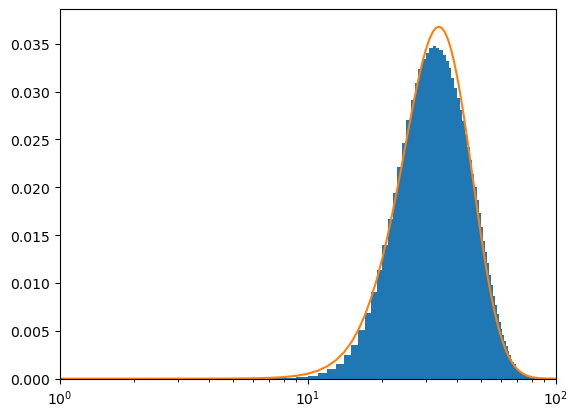

In [12]:
min = Int(minimum(p))
max = Int(maximum(p))
bins = Array(min:1:max)
x = LinRange(1,125, 125)
y = negative_binomial(
    x,
    CanonicalTwoStageModel.p_time_av(alph, beta, gamma, T),
    sqrt(CanonicalTwoStageModel.p_var_time_av(alph, beta, gamma, T))
)

plt.xscale("log")
hist(p, density=true, bins=bins)
plot(x, y)
xlim([1,100])
savefig("../../data/distributions/model_II.svg")

In [13]:
println(mean(p))
println(mean(m))

36.71690209433128
4.466033415875561


## Model III

In [14]:
mwr = @reaction_network begin
    alpha,  0-->m
    beta, m + r-->p + m + r
    gamma,  m-->0
    rho, 0-->r
end alpha beta gamma rho

Model ##ReactionSystem#255 with 4 equations
States (3):
  m(t)
  r(t)
  p(t)
Parameters (4):
  alpha
  beta
  gamma
  rho

In [15]:
alph = 1.0
gamma = 0.2
rho = 0.2
T=27.5
beta = 0.99*beta_3_exact(0.2, gamma, rho, T)


sol = simulate_cycle(mwr, [alph, beta, gamma, rho], 0.0, 5000000.0, T,
        [
            round(ModelWithRibosomes.mrna(alph, gamma, T, 0)),
            round(ModelWithRibosomes.r(rho, T, 0)),
            round(ModelWithRibosomes.p(alph, beta, gamma, rho, T, 0)),
        ],
        2.4
    )

retcode: Default
Interpolation: Piecewise constant interpolation
t: 2446971-element Array{Float64,1}:
  0.0
  2.4
  4.8
  7.2
  9.6
 12.0
 14.4
 16.8
 19.2
 21.6
 24.0
 26.4
 27.5
  ⋮
  4.99998e6
  4.9999824e6
  4.9999848e6
  4.9999872e6
  4.9999896e6
  4.999992e6
  4.9999944e6
  4.999995e6
  4.999995e6
  4.9999968e6
  4.9999992e6
  5.0e6
u: 2446971-element Array{Array{Float64,1},1}:
 [2.0, 6.0, 26.0]
 [2.0, 6.0, 27.0]
 [4.0, 6.0, 29.0]
 [4.0, 6.0, 30.0]
 [6.0, 7.0, 33.0]
 [7.0, 8.0, 37.0]
 [3.0, 8.0, 40.0]
 [5.0, 8.0, 42.0]
 [5.0, 10.0, 46.0]
 [6.0, 10.0, 47.0]
 [6.0, 10.0, 52.0]
 [4.0, 11.0, 54.0]
 [4.0, 12.0, 56.0]
 ⋮
 [7.0, 9.0, 35.0]
 [5.0, 10.0, 35.0]
 [6.0, 12.0, 39.0]
 [5.0, 12.0, 43.0]
 [2.0, 12.0, 45.0]
 [3.0, 13.0, 46.0]
 [4.0, 14.0, 47.0]
 [4.0, 14.0, 48.0]
 [3.0, 10.0, 28.0]
 [4.0, 10.0, 29.0]
 [4.0, 10.0, 31.0]
 [4.0, 10.0, 31.0]

In [16]:
p = zeros(length(sol.u))
m = zeros(length(sol.u))
for i in 1:length(sol.u)
    m[i] = sol.u[i][1]
    p[i] = sol.u[i][3]

end
p

2446971-element Array{Float64,1}:
 26.0
 27.0
 29.0
 30.0
 33.0
 37.0
 40.0
 42.0
 46.0
 47.0
 52.0
 54.0
 56.0
  ⋮
 35.0
 35.0
 39.0
 43.0
 45.0
 46.0
 47.0
 48.0
 28.0
 29.0
 31.0
 31.0

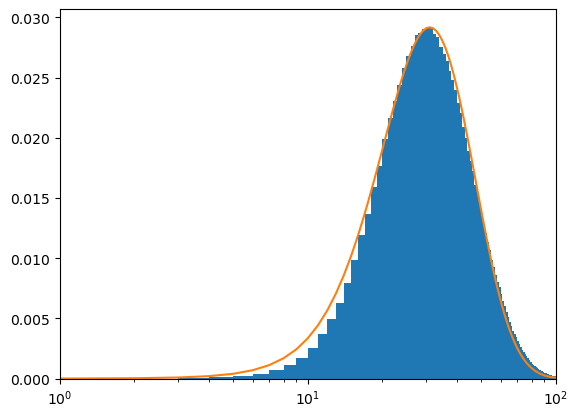

In [17]:
x = LinRange(1,125, 125)
y = negative_binomial(
    x,
    ModelWithRibosomes.p_time_av(alph, beta, gamma, rho, T),
    sqrt(ModelWithRibosomes.p_var_time_av(alph, beta, gamma, rho, T))
)
#histogram(p, normed=true, linecolor=:match, xlim=[0,250])
#plot!(x, y)
min = Int(minimum(p))
max = Int(maximum(p))
bins = Array(min:1:max)

hist(p, density=true, bins=bins)
plot(x, y)
plt.xscale("log")
xlim([1,100])
savefig("../../data/distributions/model_III.svg")

In [18]:
println(mean(p))
println(mean(m))

36.97594740599705
4.402438361549851


## Model IV

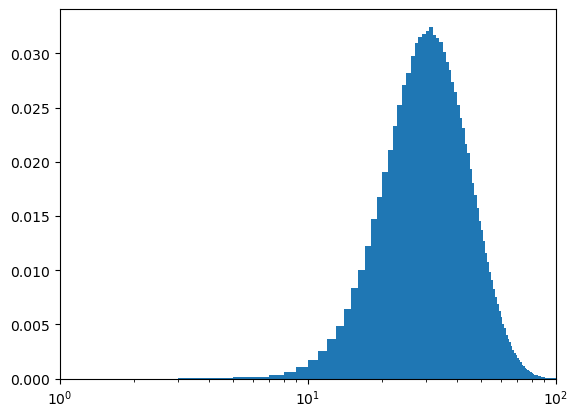

In [19]:
slc2sm = @reaction_network begin
    alpha,  0-->m
    beta, m -->p + m
    gamma,  m-->0
    k, 0-->n
end alpha beta gamma k

alph = 0.87*1.0
gamma = 0.2
T=27.5
beta = 1.05*0.2
N = 10
k = N/T

sol = simulate_stochastic_cycle(slc2sm, [alph, beta, gamma, k], 0., 1000000., T,
    [
        round(CanonicalTwoStageModel.mrna(alph, gamma, T, 0)),
        round(CanonicalTwoStageModel.approximate_protein_mean(alph, beta, gamma, T, 0)),
        0
    ],
    N,
    2.5
)

p = zeros(length(sol.u))
m = zeros(length(sol.u))
for i in 1:length(sol.u)
    m[i] = sol.u[i][1]
    p[i] = sol.u[i][2]

end
min = Int(minimum(p))
max = Int(maximum(p))
bins = Array(min:1:max)

plt.xscale("log")
xlim([1,100])
hist(p, density=true, bins=bins)
savefig("../../data/distributions/model_IV.svg")

In [20]:
println(mean(p))
println(mean(m))

35.8034485645592
4.466601832544748


## Model V

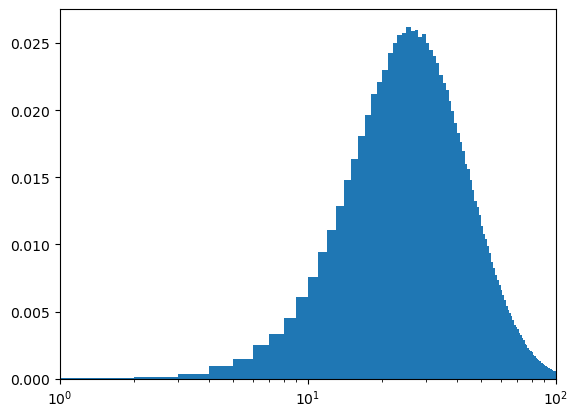

In [21]:
slm = @reaction_network begin
    alpha,  0-->m
    beta, m + r-->p + m + r
    gamma,  m-->0
    rho, 0-->r
    k, 0-->n
end alpha beta gamma rho k

alph = 0.87*1.0
gamma = 0.2
rho = 0.2
T=27.5
beta = 0.98*beta_3_exact(0.2, gamma, rho, T)
N = 10
k = N/T

sol = simulate_stochastic_cycle(slm, [alph, beta, gamma, rho, k], 0., 1000000., T,
    [
        round(ModelWithRibosomes.mrna(alph, gamma, T, 0)),
        round(ModelWithRibosomes.r(rho, T, 0)),
        round(ModelWithRibosomes.p(alph, beta, gamma, rho, T, 0)),
        0
    ],
    N,
    2.5
)

p = zeros(length(sol.u))
m = zeros(length(sol.u))
for i in 1:length(sol.u)
    m[i] = sol.u[i][1]
    p[i] = sol.u[i][3]

end
min = Int(minimum(p))
max = Int(maximum(p))
bins = Array(min:1:max)

plt.xscale("log")
xlim([1,100])
hist(p, density=true, bins=bins)
savefig("../../data/distributions/model_V.svg")

In [22]:
println(mean(p))
println(mean(m))

36.18675152856314
4.455329598258935


## Model VI

In [28]:
using DiffEqJump

alph = 0.76*1.0
gamma = 0.2
rho = 0.2
T=27.5
beta = 1.03*beta_3_exact(0.2, gamma, rho, T)
N = 10
k = N/T

R = 8 # point of replication
p = (alph, gamma, beta, rho, k)

rate1(u,p,t) = u[4] >= R ? 2 * alph : alph
function affect1!(integrator)
  integrator.u[1] += 1         # m -> m + 1
end
jump = VariableRateJump(rate1,affect1!)

rate2(u,p,t) = gamma * u[1]
function affect2!(integrator)
  integrator.u[1] -= 1         # m -> m + 1
end
jump2 = ConstantRateJump(rate2,affect2!)

rate3(u,p,t) = beta * u[1] * u[3]
function affect3!(integrator)
    integrator.u[2] += 1   # p -> p + 1
end
jump3 = ConstantRateJump(rate3, affect3!)
    
rate4(u,p,t) = rho
function affect4!(integrator)
    integrator.u[3] +=1
end
jump4=ConstantRateJump(rate4, affect4!)

rate5(u,p,t) = k
function affect5!(integrator)   # n -> n + 1
    integrator.u[4] += 1
end
jump5 = ConstantRateJump(rate5, affect5!)

function condition(u,t,integrator) # Event when event_f(u,t) == 0
    u[4] >= N
end

function affect!(integrator)
    partition = Utilities.partition_species(integrator.u[1:3])
    integrator.u[1] = partition[1]
    integrator.u[2] = partition[2]
    integrator.u[3] = partition[3]
    integrator.u[4] = 0
end

clb = DiscreteCallback(condition, affect!)

DiscreteCallback{typeof(condition),typeof(affect!),typeof(DiffEqBase.INITIALIZE_DEFAULT),typeof(DiffEqBase.FINALIZE_DEFAULT)}(condition, affect!, DiffEqBase.INITIALIZE_DEFAULT, DiffEqBase.FINALIZE_DEFAULT, Bool[1, 1])

In [29]:
tspan = (0.0,1000000.0)
function f(du,u,p,t)
  du[5] = 0
end
u₀   = [2.0,20.0,5.0, 0.0, 0.0]
prob = ODEProblem(f,u₀,tspan,p)
jump_prob = JumpProblem(prob,Direct(),jump,jump2,jump3, jump4, jump5)
sol = solve(jump_prob,Tsit5(), callback=clb) # Saveat doesn't work, need to do something else...
    
t = sol.t
m = map(x -> x[1], sol.u)
p = map(x -> x[2], sol.u)
r = map(x -> x[3], sol.u)

n = map(x -> x[4], sol.u)

┌ Warning: Interrupted. Larger maxiters is needed.
└ @ SciMLBase /Users/Louis/.julia/packages/SciMLBase/UIp7W/src/integrator_interface.jl:331


233-element Array{Int64,1}:
   1
   2
   3
   4
   5
   6
   7
   8
   9
  10
  11
  12
  13
   ⋮
 222
 223
 224
 225
 226
 227
 228
 229
 230
 231
 232
 233

In [30]:
tau = 10.0 # Frequency of time savings
t_0 = t[1]
t_max = last(t)
times = t_0:10:t_max
measurements = zeros(length(times))

function get_value_at_time(measurements, times, t)
    for i in 1:length(times)
        if t == times[i] || (t > times[i] && t < times[i+1])
            return measurements[i]
        end
    end
    return NaN
end

function convert_solution_to_evenly_spaced_measurements(counts, t, tau)
    t_0 = t[1]
    t_max = last(t)
    times = t_0:tau:t_max
    measurements = zeros(length(times))
    for i in 1:length(times)
        measurements[i] = get_value_at_time(counts, t, times[i])
    end
    measurements
end

convert_solution_to_evenly_spaced_measurements (generic function with 1 method)

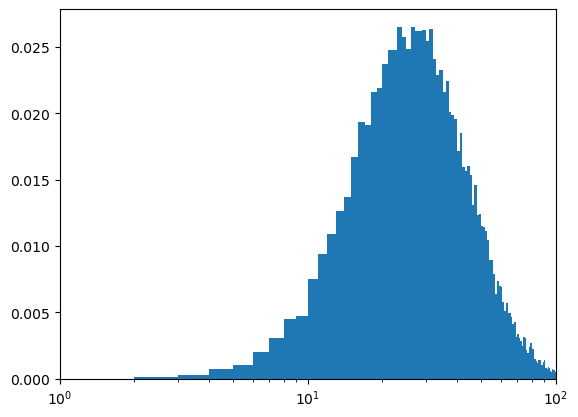

In [31]:
evenly_spaced_p = convert_solution_to_evenly_spaced_measurements(p, t, 10.0)
evenly_spaced_m = convert_solution_to_evenly_spaced_measurements(m, t, 10.0)



min = Int(minimum(evenly_spaced_p))
max = Int(maximum(evenly_spaced_p))
bins = Array(min:1:max)

plt.xscale("log")
xlim([1,100])
hist(evenly_spaced_p, density=true, bins=bins)
savefig("../../data/distributions/model_VI.svg")

In [32]:
println(mean(evenly_spaced_p))
println(mean(evenly_spaced_m))

36.21207494795281
4.461311589174184
